
Финальный проект
--

Вариант 2
--

Луговских Ирина
--

___

**Задание 1. A/B–тестирование**

**1.1 Условие**

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**1.2 Входные данные**

В качестве входных данных Вы имеете 4 csv-файла:

 - *groups.csv* - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
 - *groups_add.csv* - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
 - *active_studs.csv* - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
 - *checks.csv* - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

**1.3 Вопросы**

Предлагаем Вам ответить на следующие вопросы:

 - На какие метрики Вы смотрите в ходе анализа и почему?
 - Имеются ли различия в показателях и с чем они могут быть связаны?
 - Являются ли эти различия статистически значимыми?
 - Стоит ли запускать новую механику на всех пользователей?
 - Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

**1.4 Требования к ответу**

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

___

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency, chi2, levene, ttest_ind, bootstrap

In [2]:
active_studs = pd.read_csv('active_studs.csv')
checks = pd.read_csv('checks.csv', sep=';')
groups = pd.read_csv('groups.csv', sep=';')
group_add = pd.read_csv('group_add.csv')

**Предварительный анализ данных**

In [3]:
#функция, выводит на экран размер таблицы, количество уникальный и пропущенных значений для каждого столбца
def preliminary_analysis (df):
    print(f'Размер таблицы {df.shape}\n')
    print(f'''Уникальные значения 
{df.nunique().to_string()}\n''')
    print(f'''Пропущенные значения 
{df.isna().sum().to_string()}''')

___

In [4]:
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [5]:
preliminary_analysis(active_studs)

Размер таблицы (8341, 1)

Уникальные значения 
student_id    8341

Пропущенные значения 
student_id    0


*active_studs* - список пользователей, которые зашли на платформу в дни проведения эксперимента, все значения уникальные

___

In [6]:
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [7]:
preliminary_analysis(groups)

Размер таблицы (74484, 2)

Уникальные значения 
id     74484
grp        2

Пропущенные значения 
id     0
grp    0


*groups* - таблица с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа), все значения *id* - уникальные, названия колонок нужно изменить

In [8]:
group_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [9]:
preliminary_analysis(group_add)

Размер таблицы (92, 2)

Уникальные значения 
id     92
grp     2

Пропущенные значения 
id     0
grp    0


*group_add* - дополнительная таблица с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа), все значения *id* - уникальные, названия колонок также нужно изменить. 

In [10]:
set(groups.id) & set(group_add.id)

set()

списки id из таблиц *groups* и *group_add* не имеют пересечений

In [11]:
groups.append(group_add).grp.value_counts()
pd.DataFrame({'counts': groups.append(group_add).grp.value_counts(), 
              'normal': groups.append(group_add).grp.value_counts(normalize=True).round(2)})

C:\Users\DIMA\AppData\Local\Temp\ipykernel_11688\4005169911.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups.append(group_add).grp.value_counts()
C:\Users\DIMA\AppData\Local\Temp\ipykernel_11688\4005169911.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pd.DataFrame({'counts': groups.append(group_add).grp.value_counts(),
C:\Users\DIMA\AppData\Local\Temp\ipykernel_11688\4005169911.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'normal': groups.append(group_add).grp.value_counts(normalize=True).round(2)})


,counts,normal
B,59883,0.8
A,14693,0.2


80% пользователей попали в тестовую группу, 20% пользователей попали в контрольную группу

В рамках первого задания я буду работать только с данными из файла *groups*

___

In [12]:
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [13]:
preliminary_analysis(checks)

Размер таблицы (541, 2)

Уникальные значения 
student_id    541
rev            39

Пропущенные значения 
student_id    0
rev           0


In [14]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [15]:
pd.DataFrame({'counts': checks.rev.value_counts(), 
              'normalize': checks.rev.value_counts(normalize=True).round(2)}) \
    .head()

,counts,normalize
1900.0,97,0.18
290.0,94,0.17
690.0,78,0.14
199.0,46,0.09
990.0,41,0.08


*checks* - таблица с информацией об оплатах пользователей в дни проведения эксперимента, значения *student_id* уникальные. Для колонки *rev* нужно изменить тип данных. Мы видим, что половина платежей приходится на 3 суммы: 1900, 290, 690. Остальные 36 различных сумм составляют вторую половину. Есть необычное значение суммы - 1900.0001 - возможно это связанно с недочетами в системе сбора данных.

___

In [16]:
print(len(set(active_studs.student_id) - (set(groups.id) or set(group_add.id))))
print(len(set(checks.student_id) - (set(groups.id) or set(group_add.id))))

13
1


Для 13 пользователей, которые которые заходили на платформу в дни проведения эксперимента, не определена группа (незначительное количество - меньше 1% от всех активных пользователей).

Для 1 пользователя, совершившего оплату так же не определена группа.

Эти пользователи не будут участвовать в анализе.

In [17]:
len(set(checks.student_id) - (set(active_studs.student_id)))

149

149 пользователей совершили оплату в дни проведения эксперимента, но при этом не заходили на платформу. Это значительное количество (35% от пользователей, совершивших оплату) - не похоже на ошибку сбора данных. 

In [18]:
#list_ids - список пользователей, которые совершили оплату, но при этом не заходили на платформу
list_ids = list(set(checks.student_id) - (set(active_studs.student_id)))
pd.DataFrame({'counts': groups.append(group_add).query("id in @list_ids").grp.value_counts(), 
              'normal': groups.append(group_add).query("id in @list_ids").grp.value_counts(normalize=True).round(2)})

C:\Users\DIMA\AppData\Local\Temp\ipykernel_11688\683246622.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pd.DataFrame({'counts': groups.append(group_add).query("id in @list_ids").grp.value_counts(),
C:\Users\DIMA\AppData\Local\Temp\ipykernel_11688\683246622.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'normal': groups.append(group_add).query("id in @list_ids").grp.value_counts(normalize=True).round(2)})


,counts,normal
B,120,0.81
A,29,0.19


Мы видим, что пользователи, которые совершили оплату, но при этом не заходили на платформу распределены по группам примерно так же, как и остальные, а значит что их наличие никак не связанно с новой механикой оплаты.

Я предполагаю, что у этих пользователей подключен автоплатеж, в таком случае эти пользователи не будут участвовать в анализе, т.к. они не видели новую механику оплаты услуг. 

___

Работаем с данными только на основе файла 'groups.csv'

In [19]:
#функция для переименования колонок у таблиц с информацией о принадлежности пользователя к группе (А или В)
#изменяет исходную таблицу и возвращает ее
def rename_col (df):
    df.columns = ['student_id', 'group']
    return df

создадим новый DataFrame, в котором будет вся нужная информация о пользователях, которые участвовали в эксперименте

In [20]:
#создадим новый DataFrame в котором будут данные о принадлежности прользователей группам из файла 'groups.csv'
#предварительно приведем названия колонок к определеннму виду с помощью функции rename_col (groups)
group_all = rename_col (groups)

In [21]:
#создадим новый DataFrame test, в котором для всех активных пользователей будет информация о группе и об оплатах 
#в новом DF только активные пользователи, для которых определена группа
test = active_studs.merge(checks, how='left', on='student_id') \
                   .merge(group_all, how='inner', on='student_id')

Посмотрим, что у нас получилось

In [22]:
test.head(3)

,student_id,rev,group
0,581585,NaN,A
1,3276743,NaN,B
2,4238589,NaN,A


In [23]:
preliminary_analysis(test)

Размер таблицы (8328, 3)

Уникальные значения 
student_id    8328
rev             38
group            2

Пропущенные значения 
student_id       0
rev           7937
group            0


In [24]:
pd.DataFrame({'counts': test.group.value_counts(), 
              'normal': test.group.value_counts(normalize=True).round(2)})

,counts,normal
B,6793,0.82
A,1535,0.18


In [25]:
pd.DataFrame({'counts': test.rev.value_counts(), 
              'normal': test.rev.value_counts(normalize=True).round(2)}) \
    .head()

,counts,normal
1900.0000,92,0.24
290.0000,70,0.18
1900.0001,35,0.09
199.0000,32,0.08
840.0000,24,0.06


Значение 1900.0001 явно выбивается среди остальных значений, поэтому я воспользуюсь округлением, что бы избавиться от дробной части, а перед этим изменю тип данных колонки *rev*

In [26]:
test.rev = test.rev.astype('float').round()

In [27]:
pd.DataFrame({'counts': test.rev.value_counts(), 
              'normal': test.rev.value_counts(normalize=True).round(2)}) \
    .head()

,counts,normal
1900.0,127,0.32
290.0,70,0.18
199.0,32,0.08
840.0,24,0.06
990.0,22,0.06


Таблица *test* готова для анализа результатов эксперимента

___

По имеющимся данным мы можем рассмотреть 3 метрики:

- **CR** - конверсия
- **ARPPU** - средний доход с каждого платящего пользователя
- **ARPU** - средний доход с каждого пользователя

___

**1. CR - конверсия**

Добавим в таблицу *test* колонку *'conv'*, значение в этой колонке будет говорить на о том, совершил ли пользователь покупку в дни эксперимента или нет. (1 - пользователь совершил покупку, 0 - пользователь не совершал покупку)

In [28]:
test['conv'] = np.where(test.rev > 0, 1, 0)

Узнаем, различаются ли значения конверсии в экспериментальной и тестовой группе.

In [29]:
print('Конверсия в группе A:', (test.query("group == 'A'").conv.sum()/test.query("group == 'A'").conv.count()).round(4))
print('Конверсия в группе B:', (test.query("group == 'B'").conv.sum()/test.query("group == 'B'").conv.count()).round(4))

Конверсия в группе A: 0.0508
Конверсия в группе B: 0.0461


<AxesSubplot:xlabel='group', ylabel='Count'>

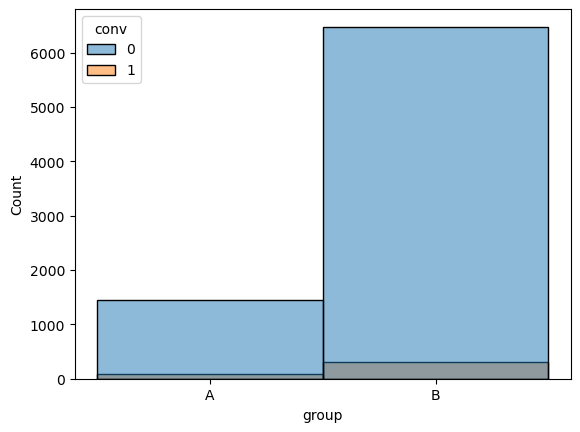

In [30]:
sns.histplot(data=test, x='group', hue='conv')

Конверсия в экспериментальной группе немного ниже чем в тестовой. Проверим, являются ли эти различия статистически значимыми.

Для этого используем Критерий Хи-квадрат

H1 - значение конверсии зависит от группы (использование новой механики оплаты уменьшило отношение платящих пользователей ко всем пользователям)

H0 - значение конверсии не зависит от группы (использование новой механики оплаты не повлияло на отношение платящих пользователей ко всем пользователям)

In [31]:
pd.crosstab(test.conv, test.group)

group,A,B
conv,,
0,1457,6480
1,78,313


In [32]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(test.conv, test.group))
stat, p

(0.526607176998989, 0.46803677583199144)

p-value > 0,05 - нет оснований отклонить нулевую гипотезу - следовательно различия не являются статистически значимыми.

Мы не можем утвержнать, что применение новой механики оплаты влияет на значение конверсии.

___

**2. ARPPU - средний доход с каждого платящего пользователя**

In [33]:
print('ARPPU в группе A:', (test.query("group == 'A'").rev.sum()/test.query("group == 'A' and conv == 1").rev.count()).round(4))
print('ARPPU в группе B:', (test.query("group == 'B'").rev.sum()/test.query("group == 'B' and conv == 1").rev.count()).round(4))

ARPPU в группе A: 933.5897
ARPPU в группе B: 1255.8275


Мы видим, что значение метрики в группе B выше. Нужно понять, является ли это различие статистически значимым.

Посмотрим на распределение сумм чеков среди оплативших пользователей 

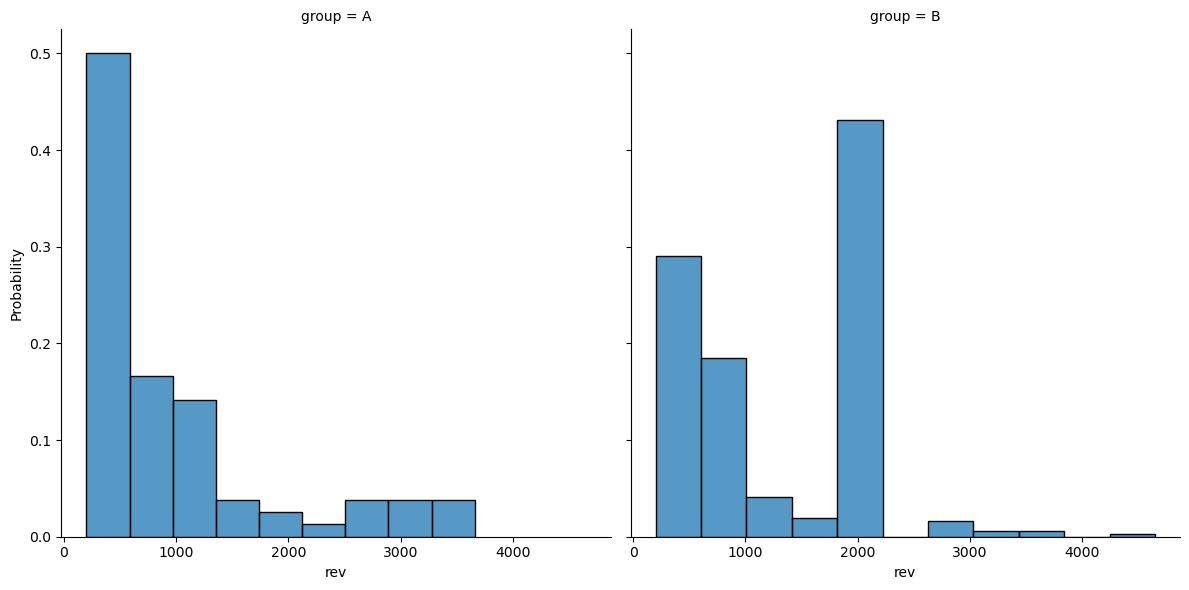

In [34]:
g = sns.FacetGrid (data=test.query("rev > 0"), col='group', height=6)
g. map (sns.histplot , 'rev', stat='probability')

На графике видно, что распределение имеет сильную положительную ассиметрию. Прологарифмируем колонку *rev* что бы распределение приобрело вид, приближенный к нормальному

In [35]:
test['rev_log'] = np.log(test.rev)

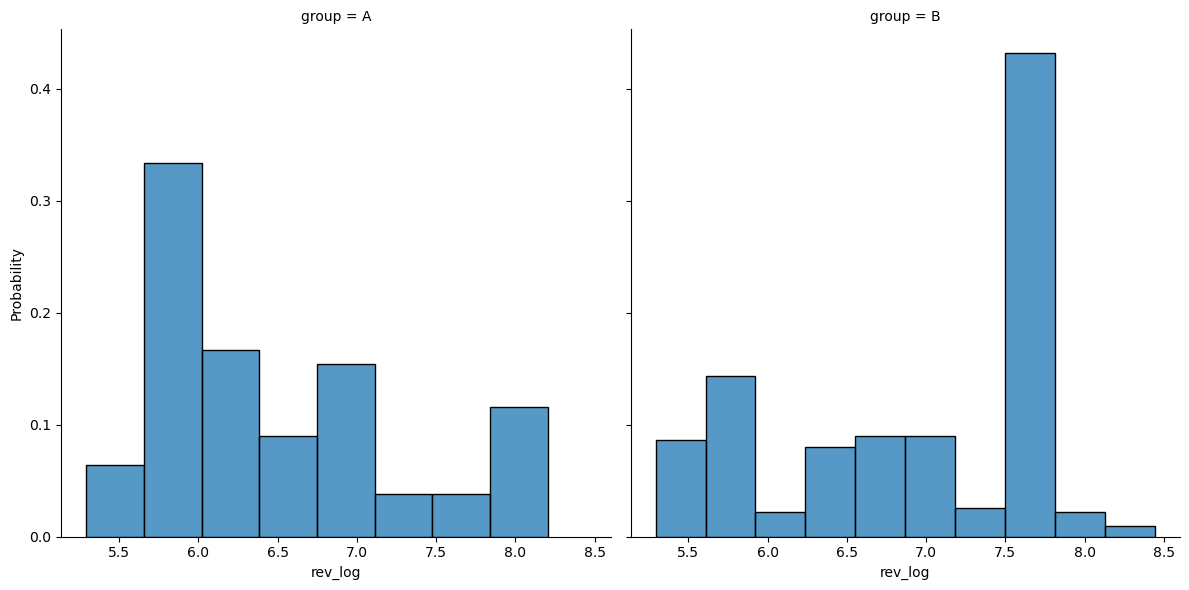

In [36]:
g = sns.FacetGrid (data=test, col='group', height=6)
g. map (sns.histplot , 'rev_log', stat='probability') 

Так распределения выглядят лучше. 

Для сравнения средних в двух выборках я планирую использовать t-тест. 

Проверим гомогенность распределений с помощью критерия Левена.

H0 - дисперсии в 2-х группах однородные (распределения являются гомогенными)

H1 - дисперсии в 2-х группах неоднородные (распределения не являются гомогенными)

In [37]:
ARPPU_A = test.query("group == 'A' and rev > 0").rev_log
ARPPU_B = test.query("group == 'B' and rev > 0").rev_log

In [38]:
levene(ARPPU_A, ARPPU_B, center='mean')

LeveneResult(statistic=0.19024733130895616, pvalue=0.6629528098544764)

p-value > 0,05 - нет оснований отклонить нулевую гипотезу - следовательно различия между дисперсиями в двух группах не являются статистически значимыми. 

Для сравнения средних в двух выборках можно использовать t-тест.

In [39]:
st, p = ttest_ind(ARPPU_A, ARPPU_B)
p

0.00026569811952692544

p-value < 0,05 - отклоняем нулевую гипотезу - следовательно различия между средними дисперсиями в двух группах являются статистически значимыми.

Я могу сделать вывод, что использование новой механики оплаты влияет на увеличение ARPPU.

___

**3. ARPAU - средний доход с каждого активного пользователя**

In [40]:
test.rev = test.rev.fillna(0)

In [41]:
print('ARPAU в группе A:', (test.query("group == 'A'").rev.sum()/test.query("group == 'A'").rev.count()).round(4))
print('ARPAU в группе B:', (test.query("group == 'B'").rev.sum()/test.query("group == 'B'").rev.count()).round(4))

ARPAU в группе A: 47.4397
ARPAU в группе B: 57.8646


Мы видим, что значение метрики в группе B выше. Нужно понять, является ли это различие статистически значимым.

Посмотрим на распределение сумм чеков среди всех активных пользователей

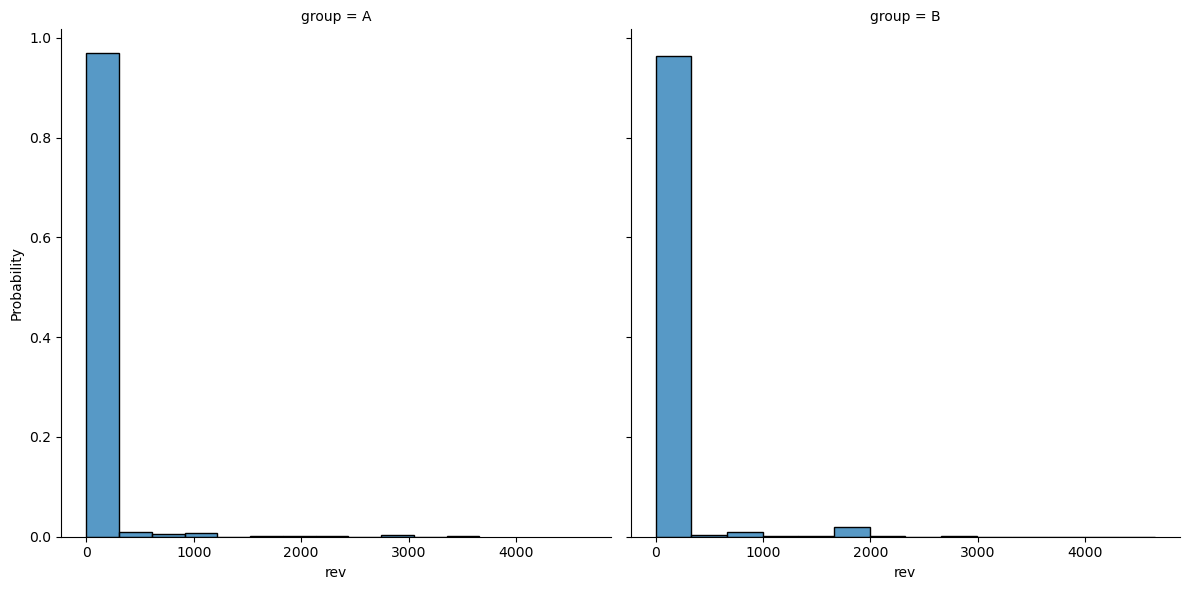

In [42]:
g = sns.FacetGrid (data=test, col='group', height=6)
g. map (sns.histplot , 'rev', stat='probability') 

Мы видим, что в двух группах распределение сильно отличается от нормального. Подавляющее большинство значений равно 0 - это те пользователи, которые не совершили оплату в дни эксперимента. 

Считаю что t-test в такой ситуации покажет неадекватные результаты.

Я буду использовать метод Bootstrap

In [43]:
ARPAU_A = test.query("group == 'A'").rev.fillna(0)
ARPAU_B = test.query("group == 'B'").rev.fillna(0)

In [44]:
ARPAU_A_ci = list(bootstrap((ARPAU_A, ), np.mean).confidence_interval)
ARPAU_B_ci = list(bootstrap((ARPAU_B, ), np.mean).confidence_interval)

In [45]:
print('Доверительный интервал для группы A: ', ARPAU_A_ci)
print('Доверительный интервал для группы В: ', ARPAU_B_ci)

Доверительный интервал для группы A:  [34.9703688888192, 64.51831155945901]
Доверительный интервал для группы В:  [50.67969585545566, 65.63196748835111]


Мы видим, что доверительные интервалы пересекаются, следовательно мы не можем отклонить нулевую гипотезу, различия между медианами ARPU в двух группах не являются статистически значимыми.

Я делаю вывод, что новая механика оплаты не влияет на медианный чек среди всех активных пользователей.

___

**Выводы:**
1. Новая механика оплаты не влияет на значение конверсии
2. Новая механика оплаты позволила увеличить значение ARPPU
3. Новая механика оплаты не влияет на значение ARPAU

___

**Задание 3. Python**

**3.1 Задача**

 - Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
 - Реализуйте функцию, которая будет строить графики по получаемым метрикам.

___

В этом файле реализованы две функции.

Первая функция, объединяет данные из файлов *groups.csv* и *group_add.csv* и на основе новых данных пересчитывает метрики
 - CR
 - ARPPU
 - ARPAU
 
функция возвращает значения метрик для двух групп, а так же определяет, являются ли различия статистически значимыми.

В файле *task_3.py* эта функция реализована в виде DAG.

Вторая функция отображает значения метрик на графиках.

In [46]:
def AB_test():
    
    path_active_studs = 'active_studs.csv'
    path_checks = 'checks.csv'
    path_groups = 'groups.csv'
    path_group_add = 'group_add.csv'
    
    
    #функция считывает файл по ссылке с Яндекс Диска
    #возвращает DataFrame
    def get_data(path, sep):
        data = pd.read_csv(path, sep=sep)
        return data
    
    #функция для добавления в таблицу с группами данных из дополнительного файла
    #изменяет названия колонок на ['student_id', 'group']
    #объединяет две таблицы, удаляет дубликаты и пропущенные значения
    #находит id_students, которые определены в две разные группы, выводит списком на экран, 
    #и не включает их в результирующую таблицу, возвращает полученную таблицу
    def add_data(df, df_add):
        
        def rename_col (df):
            df.columns = ['student_id', 'group']
            return df
        
        group_all = rename_col(df).append(rename_col(df_add)).drop_duplicates().dropna()
        error_list = group_all \
            .groupby('student_id', as_index=False).agg({'group': 'count'}) \
            .query("group > 1").student_id.to_list()
        if len(error_list) > 0:
            print('Список пользователей, которые попали одновременно в две группы:', error_list)
        group_all = group_all.query("student_id != @error_list")
        return group_all
    
    def merge_data(active_studs, checks, group_all):
        test = active_studs.merge(checks, how='left', on='student_id') \
                   .merge(group_all, how='inner', on='student_id')
        test.rev = test.rev.astype('float').round()
        test['conv'] = np.where(test.rev > 0, 1, 0)
        return test
    
    def CR(test):
        test['conv'] = np.where(test.rev > 0, 1, 0)
        CR_A = (test.query("group == 'A'").conv.sum()/test.query("group == 'A'").conv.count()).round(4)
        CR_B = (test.query("group == 'B'").conv.sum()/test.query("group == 'B'").conv.count()).round(4)
        if CR_A > CR_B:
            res_CR = f'''CR_A > CR_B
CR_A = {CR_A}
CR_B = {CR_B}'''
        else:
            res_CR = f'''CR_A < CR_B
CR_A = {CR_A}
CR_B = {CR_B}'''
        return res_CR
    
    def chi2(test):
        pd.crosstab(test.conv, test.group)
        stat, p, dof, expected = chi2_contingency(pd.crosstab(test.conv, test.group))
        if p < 0.05:
            res_chi2 = f'''Гипотезы:
H0 - различия не являются статистически значимыми
H1 - различия являются статистически значимыми
р = {p}
p < 0.05
отклоняем нулевую гипотезу
различия являются статистически значимыми
'''
        else:
            res_chi2 = f'''Гипотезы:
H0 - различия не являются статистически значимыми
H1 - различия являются статистически значимыми
р = {p}
p > 0.05
нет оснований отклонить нулевую гипотезу
различия не являются статистически значимыми
'''
        return res_chi2
            
    def ARPPU(test):
        ARPPU_A = (test.query("group == 'A'").rev.sum()/test.query("group == 'A' and conv == 1").rev.count()).round(4)
        ARPPU_B = (test.query("group == 'B'").rev.sum()/test.query("group == 'B' and conv == 1").rev.count()).round(4)
        if ARPPU_A > ARPPU_B:
            res_ARPPU = f'''ARPPU_A > ARPPU_B
ARPPU_A = {ARPPU_A}
ARPPU_B = {ARPPU_B}'''
        else:
            res_ARPPU = f'''ARPPU_A < ARPPU_B
ARPPU_A = {ARPPU_A}
ARPPU_B = {ARPPU_B}'''
        return res_ARPPU
    
    def ttest(test):
        test['rev_log'] = np.log(test.rev)
        ARPPU_A = test.query("group == 'A' and rev > 0").rev_log
        ARPPU_B = test.query("group == 'B' and rev > 0").rev_log
        st, p = ttest_ind(ARPPU_A, ARPPU_B)
        if p < 0.05:
            res_ttest = f'''Гипотезы:
H0 - различия не являются статистически значимыми
H1 - различия являются статистически значимыми
р = {p}
p < 0.05
отклоняем нулевую гипотезу
различия являются статистически значимыми
'''
        else:
            res_ttest = f'''Гипотезы:
H0 - различия не являются статистически значимыми
H1 - различия являются статистически значимыми
р = {p}
p > 0.05
нет оснований отклонить нулевую гипотезу
различия не являются статистически значимыми
'''
        return res_ttest
    
    def ARPAU(test):
        test.rev = test.rev.fillna(0)
        ARPAU_A = (test.query("group == 'A'").rev.sum()/test.query("group == 'A'").rev.count()).round(4)
        ARPAU_B = (test.query("group == 'B'").rev.sum()/test.query("group == 'B'").rev.count()).round(4)
        if ARPAU_A > ARPAU_B:
            res_ARPAU = f'''ARPAU_A > ARPAU_B
ARPAU_A = {ARPAU_A}
ARPAU_B = {ARPAU_B}'''
        else:
            res_ARPAU = f'''ARPAU_A < ARPAU_B
ARPAU_A = {ARPAU_A}
ARPAU_B = {ARPAU_B}'''
        return res_ARPAU

    def bootst(test):
        ARPAU_A = test.query("group == 'A'").rev.fillna(0)
        ARPAU_B = test.query("group == 'B'").rev.fillna(0)
        
        ARPAU_A_ci = list(bootstrap((ARPAU_A, ), np.mean).confidence_interval)
        ARPAU_B_ci = list(bootstrap((ARPAU_B, ), np.mean).confidence_interval)
        
        if ARPAU_A_ci[0] < ARPAU_B_ci[0]:
            if ARPAU_A_ci[1] < ARPAU_B_ci[0]:
                flag = False
            else:
                flag = True
        else:
            if ARPAU_B_ci[1] < ARPAU_A_ci[0]:
                flag = False
            else:
                flag = True
                
        if flag == False:
            res_bootstrap = f'''Гипотезы:
H0 - различия не являются статистически значимыми
H1 - различия являются статистически значимыми
доверительные интервалы:
ARPAU_A = {ARPAU_A_ci}
ARPAU_B = {ARPAU_B_ci}
доверительные интервалы не пересекаются
отклоняем нулевую гипотезу
различия являются статистически значимыми
'''
        else:
            res_bootstrap = f'''Гипотезы:
H0 - различия не являются статистически значимыми
H1 - различия являются статистически значимыми
доверительные интервалы:
ARPAU_A = {ARPAU_A_ci}
ARPAU_B = {ARPAU_B_ci}
доверительные интервалы пересекаются
нет оснований отклонить нулевую гипотезу
различия не являются статистически значимыми
'''
        return res_bootstrap
    
    def result(res_CR, res_chi2, res_ARPPU, res_ttest, res_ARPAU, res_bootstrap):
        print(res_CR, res_chi2, res_ARPPU, res_ttest, res_ARPAU, res_bootstrap, sep='\n')
            
        
    active_studs = get_data(path_active_studs, ',')
    checks = get_data(path_checks, ';')
    groups = get_data(path_groups, ';')
    group_add = get_data(path_group_add, ',')
    group_all = add_data(groups, group_add)
    test = merge_data(active_studs, checks, group_all)
    res_CR = CR(test)
    res_chi2 = chi2(test)
    res_ARPPU = ARPPU(test)
    res_ttest = ttest(test)
    res_ARPAU = ARPAU(test)
    res_bootstrap = bootst(test)
    result(res_CR, res_chi2, res_ARPPU, res_ttest, res_ARPAU, res_bootstrap)
    
    return test
    
new_test = AB_test()

C:\Users\DIMA\AppData\Local\Temp\ipykernel_11688\809769303.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group_all = rename_col(df).append(rename_col(df_add)).drop_duplicates().dropna()


CR_A > CR_B
CR_A = 0.0507
CR_B = 0.0462
Гипотезы:
H0 - различия не являются статистически значимыми
H1 - различия являются статистически значимыми
р = 0.48625240457231045
p > 0.05
нет оснований отклонить нулевую гипотезу
различия не являются статистически значимыми

ARPPU_A < ARPPU_B
ARPPU_A = 933.5897
ARPPU_B = 1257.879
Гипотезы:
H0 - различия не являются статистически значимыми
H1 - различия являются статистически значимыми
р = 0.0002429088191961274
p < 0.05
отклоняем нулевую гипотезу
различия являются статистически значимыми

ARPAU_A < ARPAU_B
ARPAU_A = 47.3472
ARPAU_B = 58.0588
Гипотезы:
H0 - различия не являются статистически значимыми
H1 - различия являются статистически значимыми
доверительные интервалы:
ARPAU_A = [34.99828510226197, 65.02803602544391]
ARPAU_B = [50.95808354650258, 66.16959073389155]
доверительные интервалы пересекаются
нет оснований отклонить нулевую гипотезу
различия не являются статистически значимыми



Значения метрик в группах A и B


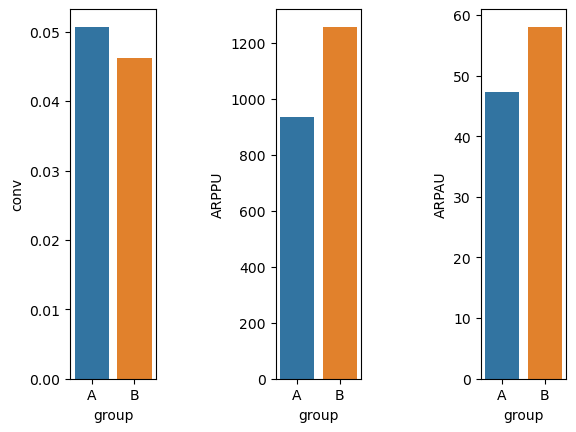

In [47]:
import matplotlib.pyplot as plt
def grafics(test):
    
    print('Значения метрик в группах A и B')
    
    df = test.groupby('group', as_index=False).agg({'conv': 'mean'})
    plt.subplot(1, 5, 1)
    sns.barplot(data=df, x='group', y='conv')
    
    df = data=test.query("rev > 0").groupby('group', as_index=False).agg({'rev': 'mean'}).rename(columns={'rev': 'ARPPU'})
    plt.subplot(1, 5, 3)
    sns.barplot(data=df, x='group', y='ARPPU')
    
    df = data=test.groupby('group', as_index=False).agg({'rev': 'mean'}).rename(columns={'rev': 'ARPAU'})
    plt.subplot(1, 5, 5)
    sns.barplot(data=df, x='group', y='ARPAU')

grafics(new_test)